In [1]:
# main source
# https://www.kaggle.com/tristcoil/iris-classification-pytorch/edit

# secondary sources
# https://medium.com/jovianml/torch-logistic-regression-on-iris-dataset-d966b23339da
# https://www.kaggle.com/aaditkapoor1201/iris-classification-pytorch


In [2]:
### GET STOCK DATA ###

In [3]:
import talib as ta
import joblib

In [4]:
import pandas as pd

#suppress 'SettingWithCopy' warning
pd.set_option('mode.chained_assignment', None)

In [5]:
#!pip install pandas_datareader
#!pip3 install seaborn
import seaborn as sns

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
#yahoo_finance.pdr_override()

%matplotlib inline

In [7]:
import talib as ta
import numpy as np

import matplotlib.pyplot as plt

# was giving me some warnings
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [8]:
# ___variables___
#ticker = 'AAPL'
#ticker = 'TSLA'
#ticker = 'FB'
#ticker = 'MSFT'
#ticker = 'NFLX'
#ticker = 'GOOGL'
ticker = 'BIDU'
#ticker = 'AMZN'
#ticker = 'IBM'

start_time = datetime.datetime(1980, 1, 1)
#end_time = datetime.datetime(2019, 1, 20)
end_time = datetime.datetime.now().date().isoformat()         # today

In [9]:
def get_data(ticker):
    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            connected = True
            print('connected to yahoo')
        except Exception as e:
            print("type error: " + str(e))
            time.sleep( 5 )
            pass   

    # use numerical integer index instead of date    
    df = df.reset_index()
    #print(df.head(5))
    return df

In [10]:
#df = get_data(ticker)

In [11]:
def compute_technical_indicators(df):
    df['EMA5'] = ta.EMA(df['Adj Close'].values, timeperiod=5)
    df['EMA10'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    df['EMA15'] = ta.EMA(df['Adj Close'].values, timeperiod=15)
    df['EMA20'] = ta.EMA(df['Adj Close'].values, timeperiod=10)
    df['EMA30'] = ta.EMA(df['Adj Close'].values, timeperiod=30)
    df['EMA40'] = ta.EMA(df['Adj Close'].values, timeperiod=40)
    df['EMA50'] = ta.EMA(df['Adj Close'].values, timeperiod=50)

    df['EMA60'] = ta.EMA(df['Adj Close'].values, timeperiod=60)
    df['EMA70'] = ta.EMA(df['Adj Close'].values, timeperiod=70)
    df['EMA80'] = ta.EMA(df['Adj Close'].values, timeperiod=80)
    df['EMA90'] = ta.EMA(df['Adj Close'].values, timeperiod=90)
    
    df['EMA100'] = ta.EMA(df['Adj Close'].values, timeperiod=100)
    df['EMA150'] = ta.EMA(df['Adj Close'].values, timeperiod=150)
    df['EMA200'] = ta.EMA(df['Adj Close'].values, timeperiod=200)

    df['upperBB'], df['middleBB'], df['lowerBB'] = ta.BBANDS(df['Adj Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    df['SAR'] = ta.SAR(df['High'].values, df['Low'].values, acceleration=0.02, maximum=0.2)

    # we will normalize RSI
    df['RSI'] = ta.RSI(df['Adj Close'].values, timeperiod=14)

    df['normRSI'] = ta.RSI(df['Adj Close'].values, timeperiod=14) / 100.0
    
    df.tail()

    return df

In [12]:
#df = compute_technical_indicators(df)

In [13]:
def compute_features(df):
    # computes features for forest decisions
    df['aboveEMA5'] = np.where(df['Adj Close'] > df['EMA5'], 1, -1)
    df['aboveEMA10'] = np.where(df['Adj Close'] > df['EMA10'], 1, -1)
    df['aboveEMA15'] = np.where(df['Adj Close'] > df['EMA15'], 1, -1)
    df['aboveEMA20'] = np.where(df['Adj Close'] > df['EMA20'], 1, -1)
    df['aboveEMA30'] = np.where(df['Adj Close'] > df['EMA30'], 1, -1)
    df['aboveEMA40'] = np.where(df['Adj Close'] > df['EMA40'], 1, -1)
    
    df['aboveEMA50'] = np.where(df['Adj Close'] > df['EMA50'], 1, -1)
    df['aboveEMA60'] = np.where(df['Adj Close'] > df['EMA60'], 1, -1)
    df['aboveEMA70'] = np.where(df['Adj Close'] > df['EMA70'], 1, -1)
    df['aboveEMA80'] = np.where(df['Adj Close'] > df['EMA80'], 1, -1)
    df['aboveEMA90'] = np.where(df['Adj Close'] > df['EMA90'], 1, -1)
    
    df['aboveEMA100'] = np.where(df['Adj Close'] > df['EMA100'], 1, -1)
    df['aboveEMA150'] = np.where(df['Adj Close'] > df['EMA150'], 1, -1)
    df['aboveEMA200'] = np.where(df['Adj Close'] > df['EMA200'], 1, -1)

    df['aboveUpperBB'] = np.where(df['Adj Close'] > df['upperBB'], 1, -1)
    df['belowLowerBB'] = np.where(df['Adj Close'] < df['lowerBB'], 1, -1)
    
    df['aboveSAR'] = np.where(df['Adj Close'] > df['SAR'], 1, -1)
   
    df['oversoldRSI'] = np.where(df['RSI'] < 30, 1, -1)
    df['overboughtRSI'] = np.where(df['RSI'] > 70, 1, -1)


    # very important - cleanup NaN values, otherwise prediction does not work
    df=df.fillna(0).copy()
    
    df.tail()

    return df

In [14]:
#df = compute_features(df)

In [15]:
def plot_train_data(df):
    # plot price
    plt.figure(figsize=(15,2.5))
    plt.title('Stock data ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'])
    #plt.title('Price chart (Adj Close) ' + str(ticker))
    plt.show()
    return None

In [16]:
def define_target_condition(df):
 
    # price higher later - bad predictive results
    #df['target_cls'] = np.where(df['Adj Close'].shift(-34) > df['Adj Close'], 1, 0)    
    
    # price above trend multiple days later
    df['target_cls'] = np.where(df['Adj Close'].shift(-55) > df.EMA150.shift(-55), 1, 0)

    # important, remove NaN values
    df=df.fillna(0).copy()
    
    df.tail()
    
    return df

In [17]:
#df = define_target_condition(df)

In [18]:
#plot_train_data(df)

### Create one big training dataframe

In [19]:
tickers = ['F', 'IBM', 'GE', 'AAPL', 'ADM',
           'XOM', 'GM','MMM','KO','PEP','SO','GS',           
           'HAS','PEAK','HPE','HLT','HD','HON','HRL','HST','HPQ','HUM','ILMN'] 
#           'INTC','ICE','INTU','ISRG','IVZ','IRM','JNJ','JPM','JNPR','K','KMB', 
#           'KIM', 'KMI','KSS','KHC', 'KR',  'LB', 'LEG', 'LIN', 'LMT','LOW',
#           'MAR', 'MA','MCD','MDT', 'MRK', 'MET', 'MGM', 'MU','MSFT', 'MAA', 
#           'MNST', 'MCO','MS', 'MSI',
#           'MMM', 'ABT','ACN','ATVI','ADBE','AMD','A','AKAM','ARE','GOOG','AMZN','AAL']


In [20]:
# parent dataframe to append to
ticker = 'SPY'
df = get_data(ticker)
df = compute_technical_indicators(df)
df = compute_features(df)
df = define_target_condition(df)




for ticker in tickers:
    t_df = get_data(ticker)
    t_df = compute_technical_indicators(t_df)
    t_df = compute_features(t_df)
    t_df = define_target_condition(t_df)
    
    df = df.append(t_df, ignore_index=True)
    
    

connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo
connected to yahoo


### Train-Test split and Training part

In [21]:
predictors_list = ['aboveSAR','aboveUpperBB','belowLowerBB','normRSI','oversoldRSI','overboughtRSI',
                   'aboveEMA5','aboveEMA10','aboveEMA15','aboveEMA20','aboveEMA30','aboveEMA40',
                   'aboveEMA50','aboveEMA60','aboveEMA70','aboveEMA80','aboveEMA90','aboveEMA100']

In [22]:
def splitting_and_training(df, predictors_list, test_size=0.3):
    # __predictors__


    # __features__
    X = df[predictors_list].fillna(0).values
    #X.tail()

    # __targets__
    y_cls = df.target_cls.fillna(0).values
    #y_cls.tail(10)

    # __train test split__
    from sklearn.model_selection import train_test_split
    y=y_cls
    X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    print (X_cls_train.shape, y_cls_train.shape)
    print (X_cls_test.shape, y_cls_test.shape)

    return X_cls_train, X_cls_test, y_cls_train, y_cls_test

In [23]:
############ START OF MAIN SOURCE ###############

In [24]:
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
import torch.nn.functional as F

Using TensorFlow backend.
/home/coil/anaconda3/envs/decision_trees/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/coil/anaconda3/envs/decision_trees/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/coil/anaconda3/envs/decision_trees/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/h

In [25]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim,500)
        self.layer2 = nn.Linear(500, 100)
        self.layer3 = nn.Linear(100, 2)
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.drop(x)
        x = F.relu(self.layer2(x))
        x = self.drop(x)
        x = F.softmax(self.layer3(x)) # To check with the loss function
        return x

### Features, Labels

In [26]:
#features, labels = load_iris(return_X_y=True)

In [27]:
#features[:3]

In [28]:
#labels[:3]

In [29]:
#features_train,features_test, labels_train, labels_test = train_test_split(features, labels, random_state=42, shuffle=True)

In [30]:
# mine version
# so far the variables are dataframes, not arrays or tensors
features_train,features_test, labels_train, labels_test = splitting_and_training(df, predictors_list)

(143512, 18) (143512,)
(61506, 18) (61506,)


In [31]:
features_train[:3]

array([[-1.        , -1.        , -1.        ,  0.51821397, -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ],
       [-1.        , -1.        , -1.        ,  0.48747654, -1.        ,
        -1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        ,  0.61345433, -1.        ,
        -1.        , -1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ]])

In [32]:
labels_train[:3]

array([1, 0, 1])

In [33]:
# make data tensors
features_train = Variable(torch.Tensor(features_train).float())
features_test  = Variable(torch.Tensor(features_test).float())
labels_train   = Variable(torch.Tensor(labels_train).long())
labels_test    = Variable(torch.Tensor(labels_test).long())

x_train = features_train
y_train = labels_train

In [34]:
# Training
model = Model(features_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
epochs = 200

def print_(loss):
    print ("The loss calculated: ", loss)

In [35]:
# Not using dataloader
#######x_train, y_train = Variable(torch.from_numpy(features_train)).float(), Variable(torch.from_numpy(labels_train)).long()
for epoch in range(1, epochs+1):
    print ("Epoch #",epoch)
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    print_(loss.item())
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward() # Gradients
    optimizer.step() # Update

Epoch # 1


/home/coil/anaconda3/envs/decision_trees/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


The loss calculated:  0.6852626800537109
Epoch # 2
The loss calculated:  0.6196837425231934
Epoch # 3
The loss calculated:  0.5974315404891968
Epoch # 4
The loss calculated:  0.6032636165618896
Epoch # 5
The loss calculated:  0.5984591245651245
Epoch # 6
The loss calculated:  0.5936050415039062
Epoch # 7
The loss calculated:  0.5932214260101318
Epoch # 8
The loss calculated:  0.5939201712608337
Epoch # 9
The loss calculated:  0.5932767391204834
Epoch # 10
The loss calculated:  0.5925727486610413
Epoch # 11
The loss calculated:  0.5921405553817749
Epoch # 12
The loss calculated:  0.5918112993240356
Epoch # 13
The loss calculated:  0.5916013121604919
Epoch # 14
The loss calculated:  0.5914506316184998
Epoch # 15
The loss calculated:  0.5913875699043274
Epoch # 16
The loss calculated:  0.5911760926246643
Epoch # 17
The loss calculated:  0.5910252928733826
Epoch # 18
The loss calculated:  0.5909638404846191
Epoch # 19
The loss calculated:  0.5907496809959412
Epoch # 20
The loss calculated:

In [36]:
# Prediction
######x_test = Variable(torch.from_numpy(features_test)).float()
x_test = features_test

pred = model(x_test)

/home/coil/anaconda3/envs/decision_trees/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [37]:
pred = pred.detach().numpy()

In [38]:
pred

array([[6.3500744e-07, 9.9999940e-01],
       [1.2752749e-27, 1.0000000e+00],
       [9.4866045e-02, 9.0513396e-01],
       ...,
       [2.0408326e-05, 9.9997962e-01],
       [1.8100294e-05, 9.9998188e-01],
       [2.7623303e-16, 1.0000000e+00]], dtype=float32)

# ACCURACY

In [39]:
print ("The accuracy is", accuracy_score(labels_test, np.argmax(pred, axis=1)))

The accuracy is 0.6940298507462687


In [40]:
# Checking for first value
np.argmax(model(x_test[0]).detach().numpy(), axis=0)

/home/coil/anaconda3/envs/decision_trees/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


1

In [41]:
labels_test[0]

tensor(1)

In [42]:
torch.save(model, "iris-pytorch.pkl")

/home/coil/anaconda3/envs/decision_trees/lib/python3.5/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [43]:
saved_model = torch.load("iris-pytorch.pkl")

In [44]:
np.argmax(saved_model(x_test[0]).detach().numpy(), axis=0)

/home/coil/anaconda3/envs/decision_trees/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


1

In [45]:
x_test[0]

tensor([-1.0000, -1.0000, -1.0000,  0.6179, -1.0000, -1.0000, -1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000])

In [46]:
for i in x_test[:3]:
    print(i)
    prediction = np.argmax(saved_model(i).detach().numpy(), axis=0)
    print('prediction', prediction)

tensor([-1.0000, -1.0000, -1.0000,  0.6179, -1.0000, -1.0000, -1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000])
prediction 1
tensor([-1.0000,  1.0000, -1.0000,  0.7082, -1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000])
prediction 1
tensor([ 1.0000, -1.0000, -1.0000,  0.5687, -1.0000, -1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000])
prediction 1


/home/coil/anaconda3/envs/decision_trees/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [47]:
############ END OF MAIN SOURCE ###############

## PREDICTION ON UNKNOWN DATA

In [48]:
#ticker='BP'
#ticker='ABBV'
#ticker='GILD'
#ticker='NGG'
ticker='BPY'

In [49]:
def plot_stock_prediction(df, ticker):
    # plot  values and significant levels
    plt.figure(figsize=(20,7))
    plt.title('Predictive model ' + str(ticker))
    plt.plot(df['Date'], df['Adj Close'], label='High', alpha=0.2)

    plt.plot(df['Date'], df['EMA10'], label='EMA10', alpha=0.2)
    plt.plot(df['Date'], df['EMA20'], label='EMA20', alpha=0.2)
    plt.plot(df['Date'], df['EMA30'], label='EMA30', alpha=0.2)
    plt.plot(df['Date'], df['EMA40'], label='EMA40', alpha=0.2)
    plt.plot(df['Date'], df['EMA50'], label='EMA50', alpha=0.2)
    plt.plot(df['Date'], df['EMA100'], label='EMA100', alpha=0.2)
    plt.plot(df['Date'], df['EMA150'], label='EMA150', alpha=0.99)
    plt.plot(df['Date'], df['EMA200'], label='EMA200', alpha=0.2)


    plt.scatter(df['Date'], df['Buy']*df['Adj Close'], label='Buy', marker='^', color='magenta', alpha=0.15)
    #lt.scatter(df.index, df['sell_sig'], label='Sell', marker='v')

    plt.legend()

    plt.show()

    return None   

In [50]:
new_df = get_data(ticker)

connected to yahoo


In [51]:
new_df = compute_technical_indicators(new_df)

In [52]:
new_df = compute_features(new_df)

In [53]:
new_df=define_target_condition(new_df)

In [54]:
saved_model = torch.load("iris-pytorch.pkl")

In [55]:
def predict_timeseries(df):
    
    # making sure we have good dimensions
    # column will be rewritten later
    df['Buy'] = df['target_cls']
    
    for i in range(len(df)):
        X_cls_valid = [[df['aboveSAR'][i],df['aboveUpperBB'][i],df['belowLowerBB'][i],
                        df['normRSI'][i],df['oversoldRSI'][i],df['overboughtRSI'][i],
                        df['aboveEMA5'][i],df['aboveEMA10'][i],df['aboveEMA15'][i],df['aboveEMA20'][i],
                        df['aboveEMA30'][i],df['aboveEMA40'][i],df['aboveEMA50'][i],
                        df['aboveEMA60'][i],df['aboveEMA70'][i],df['aboveEMA80'][i],df['aboveEMA90'][i],
                        df['aboveEMA100'][i]]]    

        x_test = Variable(torch.Tensor(X_cls_valid).float())    
        
        #####print('x_test',x_test)
        

        #####print('i',i)
        prediction = np.argmax(saved_model(x_test[0]).detach().numpy(), axis=0)
        #####print('prediction', prediction)        
  
    
        df['Buy'][i] = prediction


    print(df.head())    
        
    return df

In [56]:
new_df = predict_timeseries(new_df)

/home/coil/anaconda3/envs/decision_trees/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


        Date       High        Low       Open      Close    Volume  Adj Close       EMA5  EMA10  EMA15  ...  aboveEMA100  aboveEMA150  aboveEMA200  aboveUpperBB  belowLowerBB  aboveSAR  oversoldRSI  overboughtRSI  target_cls  Buy
0 2013-03-22  25.000000  21.000000  21.000000  22.030001  314200.0  13.484918   0.000000    0.0    0.0  ...           -1           -1           -1            -1            -1        -1           -1             -1           1    1
1 2013-03-25  22.250000  21.170000  22.090000  21.639999  125000.0  13.246187   0.000000    0.0    0.0  ...           -1           -1           -1            -1            -1        -1           -1             -1           1    1
2 2013-03-26  21.799999  21.129999  21.500000  21.280001  602800.0  13.025826   0.000000    0.0    0.0  ...           -1           -1           -1            -1            -1        -1           -1             -1           1    1
3 2013-03-27  21.959999  21.129999  21.280001  21.360001  628600.0  13.074796   

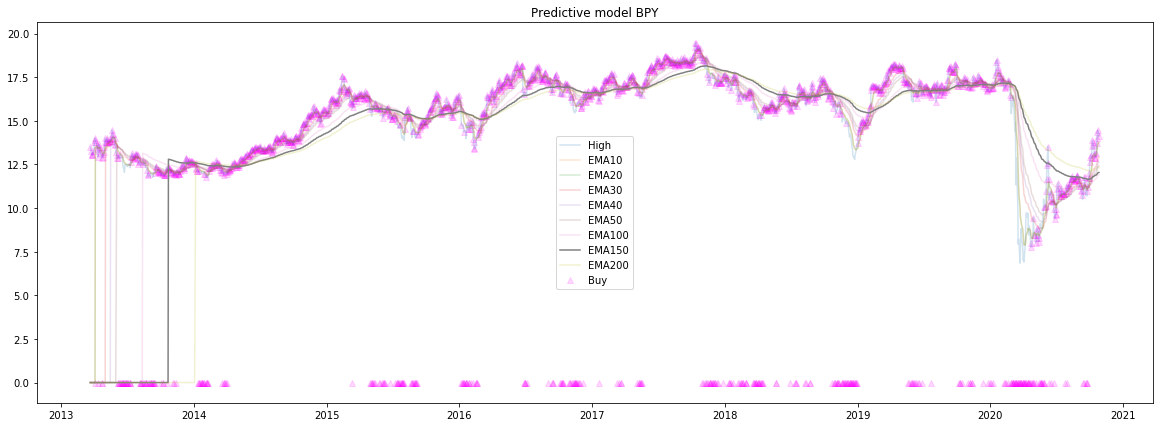

In [57]:
plot_stock_prediction(new_df, ticker)

In [58]:
# zoom in on the data
temp_df = new_df[-700:]

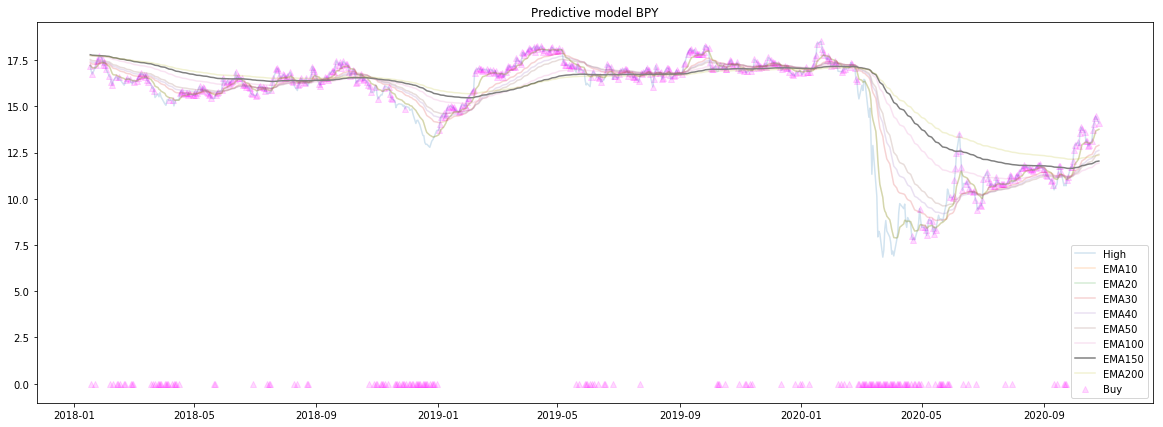

In [59]:
plot_stock_prediction(temp_df, ticker)